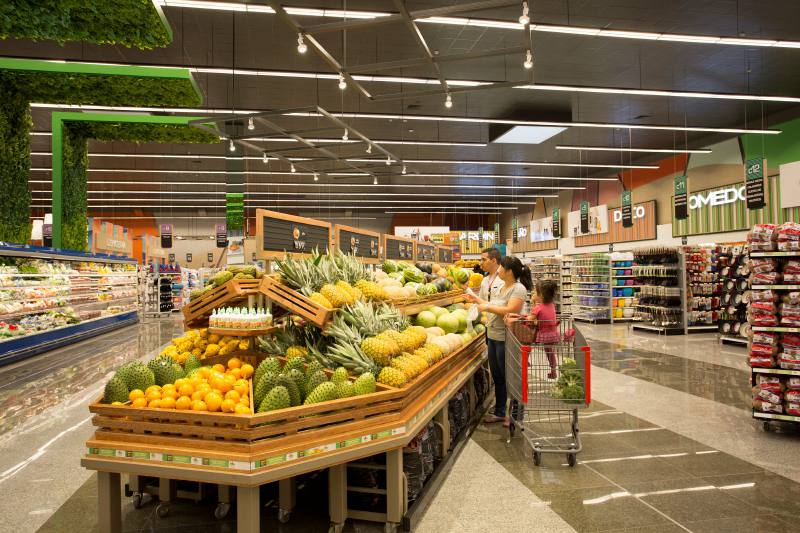

# Forecasting Favorita Store Sales using Machine Learning

<a name="table"></a> TABLE CONTENTS

[I. Introduction](#intro)

[II. Exploratory Data Analysis](#eda)

[III. Feature Engineering](#fe)

[IV. Evaluation Metrics](#eval)

[V. Model Selection](#ml)

[VI. Tune Hyperparameters](#hyper)

[VII. Exponentianal Moving Average](#ema)

[VIII. Conclusion](#sum)

[IX. References](#ref)

## <a name="intro"></a> 1. Introduction

[Favorita Corporation](https://www.corporacionfavorita.com/en/) develops commercial, industrial and real estate areas, present in Ecuador and 6 other countries in the region. They opened La Favorita supermarkets in country called Ecudor in South America which was the first self-service store in 1957.


In this project we’ll use time-series forecasting to forecast store sales on data from Corporación Favorita, a large Ecuadorian-based grocery retailer. Kaggle has published a knowledge based compitition to predict store sales by providing Favorita Corporation Stores data. 
[Learn more](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview)

https://rpubs.com/yongks/favorita

### 1.1 Loading Data

In [2]:
# Downloading Data
!pip install opendatasets --upgrade --quiet
import opendatasets as od

In [3]:
Kaggle_url = 'https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data'
od.download(Kaggle_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pratulperla
Your Kaggle Key: ··········


100%|██████████| 21.4M/21.4M [00:00<00:00, 182MB/s]


Extracting archive ./store-sales-time-series-forecasting/store-sales-time-series-forecasting.zip to ./store-sales-time-series-forecasting


In [4]:
import os
os.listdir("store-sales-time-series-forecasting")

['sample_submission.csv',
 'oil.csv',
 'train.csv',
 'stores.csv',
 'transactions.csv',
 'test.csv',
 'holidays_events.csv']

In [5]:
import glob
path = './store-sales-time-series-forecasting'
glob.glob(path+"/"+"*.csv")

['./store-sales-time-series-forecasting/sample_submission.csv',
 './store-sales-time-series-forecasting/oil.csv',
 './store-sales-time-series-forecasting/train.csv',
 './store-sales-time-series-forecasting/stores.csv',
 './store-sales-time-series-forecasting/transactions.csv',
 './store-sales-time-series-forecasting/test.csv',
 './store-sales-time-series-forecasting/holidays_events.csv']

In [6]:
import pandas as pd

In [7]:
train_df = pd.read_csv('./store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('./store-sales-time-series-forecasting/test.csv')
stores_df = pd.read_csv('./store-sales-time-series-forecasting/stores.csv')
holidays_df = pd.read_csv('./store-sales-time-series-forecasting/holidays_events.csv')
transactions_df = pd.read_csv('./store-sales-time-series-forecasting/transactions.csv')
oil_df = pd.read_csv('./store-sales-time-series-forecasting/oil.csv')
sample_sub_df = pd.read_csv('./store-sales-time-series-forecasting/sample_submission.csv')

In [10]:
train_df.shape, train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


((3000888, 6), None)

In [11]:
test_df.shape, test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


((28512, 5), None)

In [13]:
test_df.date.min(), test_df.date.max()

('2017-08-16', '2017-08-31')


**Data Info**

> There are 54 stores and 33 prodcut families in the data. 

> 22 cities, 16 states

> 5 types of stores A, B, C, D.

> 17 clusters, is a grouping of similar stores.

However, Kaggle gave us splitted the data as train and test.

### 1.2 Data Preparation

#### Data Cleaning

In [16]:
import warnings
warnings.filterwarnings("ignore")

In [17]:
print("****************************training_df\n", train_df.isna().sum())
print("****************************stores_df\n",stores_df.isna().sum())
print("****************************holidays_df\n",holidays_df.isna().sum())
print("****************************transactions_df\n",transactions_df.isna().sum())
print("****************************test_df\n",test_df.isna().sum())
print("****************************oil_df\n",oil_df.isna().sum())

****************************training_df
 id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64
****************************stores_df
 store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
****************************holidays_df
 date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
****************************transactions_df
 date            0
store_nbr       0
transactions    0
dtype: int64
****************************test_df
 id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64
****************************oil_df
 date           0
dcoilwtico    43
dtype: int64


Here in the oil data containes some NaN values. My strategy is replacing it by taking a mean value of upper and lower row values of a NaN value row.

In [18]:
import numpy as np
oil_df.dcoilwtico[0]=93.00

In [19]:
for i in list(oil_df[oil_df.dcoilwtico.isna()].index):
  p= i-1
  c= i+1
  mean = np.mean([oil_df.dcoilwtico[p],oil_df.dcoilwtico[c]])
  oil_df.dcoilwtico[i]=mean

In [20]:
oil_df[oil_df.dcoilwtico.isna()]

,date,dcoilwtico
1174,2017-07-03,NaN
1175,2017-07-04,NaN


In [22]:
print(oil_df.loc[1173])
oil_df.dcoilwtico[1174]=46.02
oil_df.dcoilwtico[1175]=46.02

date          2017-06-30
dcoilwtico         46.02
Name: 1173, dtype: object


#### Data Manipulation

In [23]:
train_df["date"] = pd.to_datetime(train_df["date"])
test_df["date"] = pd.to_datetime(test_df["date"])
transactions_df["date"] = pd.to_datetime(transactions_df["date"])
oil_df["date"] = pd.to_datetime(oil_df["date"])
holidays_df["date"] = pd.to_datetime(holidays_df["date"])

In [24]:
final_train_df = pd.merge(train_df, stores_df, on='store_nbr', how='left')
final_test_df = pd.merge(test_df, stores_df, on='store_nbr', how='left')
final_train_df = pd.merge(final_train_df, oil_df, on='date', how='left')
final_test_df = pd.merge(final_test_df, oil_df, on='date', how='left')

In [25]:
holidays_df.rename(columns = {'locale_name':'city', 'type': 'day_type'},inplace=True)
holidays_df.drop('description',axis=1,inplace=True)

In [26]:
final_train_df = pd.merge(final_train_df, holidays_df, on=['date','city'], how='left')
final_test_df = pd.merge(final_test_df, holidays_df, on=['date','city'], how='left')

In [31]:
# Apart from holidays all are working days
final_train_df['day_type'].fillna('working_day',inplace=True)
final_test_df['day_type'].fillna('working_day',inplace=True)
# Filling the blanks with the value before nan
final_train_df['dcoilwtico'].fillna(method = 'ffill', inplace=True)
final_test_df['dcoilwtico'].fillna(method = 'ffill', inplace=True)
# All the NaN value in 'locale' column are working days hence it is National
final_train_df['locale'].fillna('National', inplace=True)
final_test_df['locale'].fillna('National', inplace=True)
# All the NaN values are working days hence not tranferred
final_train_df['transferred'].fillna(False, inplace=True)
final_test_df['transferred'].fillna(False, inplace=True)

final_train_df.rename(columns = {'type': 'store_type'},inplace=True)
final_test_df.rename(columns = {'type': 'store_type'},inplace=True)

In [32]:
def replace_fam_vals(df):
  df.replace('HOME APPLIANCES','HOME_APPLIANCES',inplace=True)
  df.replace('BABY CARE','BABY_CARE',inplace=True)
  df.replace('BREAD/BAKERY','BREAD_BAKERY',inplace=True)
  df.replace('FROZEN FOODS','FROZEN_FOODS',inplace=True)
  df.replace('GROCERY I','GROCERY_I',inplace=True)
  df.replace('GROCERY II','GROCERY_II',inplace=True)
  df.replace('HOME AND KITCHEN I','HOME_AND_KITCHEN_I',inplace=True)
  df.replace('HOME AND KITCHEN II','HOME_AND_KITCHEN_II',inplace=True)
  df.replace('HOME CARE','HOME_CARE',inplace=True)
  df.replace('LAWN AND GARDEN','LAWN_AND_GARDEN',inplace=True)
  df.replace('LIQUOR,WINE,BEER','LIQUOR_WINE_BEER',inplace=True)
  df.replace('PERSONAL CARE','PERSONAL_CARE',inplace=True)
  df.replace('PET SUPPLIES','PET_SUPPLIES',inplace=True)
  df.replace('PLAYERS AND ELECTRONICS','PLAYERS_AND_ELECTRONICS',inplace=True)
  df.replace('PREPARED FOODS','PREPARED_FOODS',inplace=True)
  df.replace('SCHOOL AND OFFICE SUPPLIES','SCHOOL_AND_OFFICE_SUPPLIES',inplace=True)
  return df

In [ ]:
replace_fam_vals(final_train_df.family)
replace_fam_vals(final_test_df.family)

In [34]:
final_train_df['store_nbr']= final_train_df['store_nbr'].astype('uint8')
final_train_df['sales']= final_train_df['sales'].astype('float64')
final_train_df['onpromotion']= final_train_df['onpromotion'].astype('uint16')
final_train_df['cluster']= final_train_df['cluster'].astype('uint8')
final_train_df['dcoilwtico']= final_train_df['dcoilwtico'].astype('float64')
final_train_df['transferred'] = final_train_df['transferred'].astype('uint8')
############
final_test_df['store_nbr']= final_test_df['store_nbr'].astype('uint8')
final_test_df['onpromotion']= final_test_df['onpromotion'].astype('uint16')
final_test_df['cluster']= final_test_df['cluster'].astype('uint8')
final_test_df['dcoilwtico']= final_test_df['dcoilwtico'].astype('float64')
final_test_df['transferred'] = final_test_df['transferred'].astype('uint8')

In [30]:
final_train_df.shape, final_test_df.shape

((3001152, 14), (28512, 13))

Finally we've ended up with 

> 30M+ rows 14 features of train data from 2013-01-01 to 2017-08-15

> 28K+ rows 13 features of test data from 2017-08-16 to 2017-08-31

## <a name="eda"></a> 2. Exploratory Data Analysis

In [43]:
!pip install seaborn plotly --upgrade --quiet
!pip install matplotlib==3.1.3 --quiet

     |████████████████████████████████| 288 kB 25.4 MB/s 
     |████████████████████████████████| 15.3 MB 49.6 MB/s 
     |████████████████████████████████| 13.1 MB 26.2 MB/s 


In [44]:
#Visualisation libraries
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.figure_factory as ff
import plotly.offline as offline
import plotly.graph_objs as go
%matplotlib inline

There's an additional note about the data

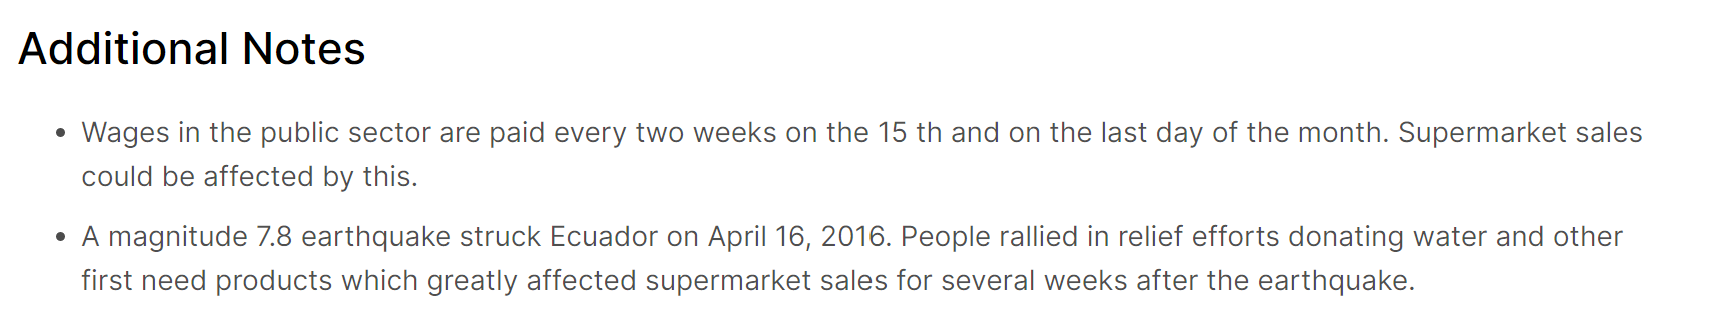

**Did Earhquake affect the store sales?**


Comparing average sales by year, month and product family will be one of the best ways to be able to understand how earthquake had affected the store sales.

We can use the data of March, April, May and June and there may be increasing or decrasing sales for some product families.

Lastly, we extracted a column for earthquake from Holidays and Events data. "events_Terremoto_Manabi" column will help to fit a better model.

In [54]:
pd.pivot_table(final_train_df[(final_train_df.date.dt.month.isin([3]))], 
               index=final_train_df.date.dt.year, columns="family", 
               values="sales", aggfunc="mean")

family,AUTOMOTIVE,BABY_CARE,BEAUTY,BEVERAGES,BOOKS,BREAD_BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL_CARE,PET_SUPPLIES,PLAYERS_AND_ELECTRONICS,POULTRY,PREPARED_FOODS,PRODUCE,SCHOOL_AND_OFFICE_SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013,4.560932,0.000000,2.330346,1088.542413,0.000000,354.853526,0.000000,899.277180,365.894863,195.494296,...,0.000000,313.938676,190.713262,0.000000,0.000000,190.441733,90.362182,2.411589,0.000000,23.941057
2014,6.042413,0.043011,3.086022,2646.471924,0.000000,388.987692,12.830346,1057.511350,709.575269,227.415349,...,1.170251,332.993349,231.297491,4.785544,9.594385,390.943043,97.848576,2002.596327,1.335125,23.890751
2015,6.902031,0.000000,2.538232,1385.922342,0.000000,500.669417,0.000000,1115.107527,737.664875,301.454903,...,0.000000,326.473811,289.569892,0.000000,0.000000,384.931138,95.655186,4.124851,0.000000,26.169936
2016,7.203106,0.264038,4.261051,2967.511947,0.000000,492.651516,13.970131,1057.762843,843.405018,272.667234,...,5.959976,324.644176,290.982676,5.780765,8.557945,368.022836,107.821004,2262.134630,1.922342,23.449707
2017,7.642772,0.264038,4.212067,3664.010155,0.281959,573.421241,13.947431,1197.510753,972.788530,320.441513,...,6.161888,367.350973,325.296894,8.627838,11.180406,388.023902,111.916694,2396.963142,4.925926,25.063907


In [55]:
pd.pivot_table(final_train_df[(final_train_df.date.dt.month.isin([4,5]))], 
               index=final_train_df.date.dt.year, columns="family", 
               values="sales", aggfunc="mean")

family,AUTOMOTIVE,BABY_CARE,BEAUTY,BEVERAGES,BOOKS,BREAD_BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL_CARE,PET_SUPPLIES,PLAYERS_AND_ELECTRONICS,POULTRY,PREPARED_FOODS,PRODUCE,SCHOOL_AND_OFFICE_SUPPLIES,SEAFOOD
date,,,,,,,,,,,,,,,,,,,,,
2013,5.014876,0.000000,2.242259,1082.952034,0.000000,359.644466,0.000000,882.671828,350.712508,201.413805,...,0.000000,324.426293,192.935641,0.000000,0.000000,190.306378,83.029393,4.597450,0.000000,21.784354
2014,5.009411,0.000000,2.277171,1273.498179,0.000000,362.751029,0.000000,895.743169,667.948087,220.910857,...,0.000000,315.064507,232.140559,0.000000,0.000000,353.101281,90.148191,4.931998,0.000000,20.587511
2015,5.578628,0.000000,2.744384,1773.299029,0.000000,510.743057,0.000000,1136.955677,751.210686,305.372233,...,1.560413,338.189490,291.105647,0.056466,0.000000,384.711418,94.849472,5.262599,0.000000,25.042594
2016,7.125076,0.248937,4.782332,3306.877656,0.000000,541.683519,13.982696,1195.784153,894.969945,293.737588,...,6.649362,356.768421,356.734973,6.716151,10.471767,391.973237,106.654130,2263.000637,5.882514,24.095966
2017,7.585610,0.175167,5.272010,3572.213722,0.124469,554.622325,13.642684,1300.468731,965.250152,321.342451,...,6.828780,360.316119,324.120826,9.014268,12.149059,383.165297,95.756706,2391.040075,11.641469,23.038335


In [56]:
#March
march= pd.pivot_table(final_train_df[(final_train_df.date.dt.month.isin([3]))], 
               index=final_train_df.date.dt.year, 
               columns="family", values="sales", aggfunc="mean")
march= march.sum(axis=1).reset_index()
march['month']= 'march'
#April
april= pd.pivot_table(final_train_df[(final_train_df.date.dt.month.isin([4]))], 
               index=final_train_df.date.dt.year, 
               columns="family", values="sales", aggfunc="mean")
april= april.sum(axis=1).reset_index()
april['month']= 'april'
# May
may= pd.pivot_table(final_train_df[(final_train_df.date.dt.month.isin([5]))], 
               index=final_train_df.date.dt.year, 
               columns="family", values="sales", aggfunc="mean")
may= may.sum(axis=1).reset_index()
may['month']= 'may'

In [57]:
ee= march.append(april).append(may).reset_index().drop(['index'], axis=1)
trace1 = go.Bar(x=ee.date, y=ee[0][ee.month=='march'],
                marker=dict(color='#bbe070'),
                name='March')
trace2 = go.Bar(x=ee.date, y=ee[0][ee.month=='april'],
                marker=dict(color='#f77e90'),
                name='April')
trace3 = go.Bar(x=ee.date, y=ee[0][ee.month=='may'],
                marker=dict(color='#bbe070'),
                name='May')
data = [trace1, trace2, trace3]

fig = go.Figure(data = data)
fig.layout.update({'title': 'Earthquake Effect On Sales'})
fig.layout.update({'width':700,'height':400})
fig.update_layout(title_x=0.5)
fig.show()

Top 10 Products


In [60]:
df_fa_sa = final_train_df.groupby('family').agg({"sales" : "mean"}).reset_index().sort_values(by='sales',
                                                                                              ascending=False)[:10]
df_fa_sa['color'] = '#71c7ec'
df_fa_sa['color'][2:] = '#107dac'
trace = go.Bar(x=df_fa_sa['sales'], y=df_fa_sa['family'],
               marker=dict(color= df_fa_sa['color']),
               name='Family', orientation='h')

fig = go.Figure(data = trace)
fig.layout.update({'title': 'Top 10 Product Sales'})
fig.layout.update({'width':700,'height':400})
fig.update_yaxes(showgrid=False, ticksuffix=' ', categoryorder='total ascending')
fig.update_xaxes(visible=False)
fig.update_layout(title_x=0.5)
fig.show()

In [68]:
p= pd.DataFrame({'A': final_train_df[final_train_df['store_type']=='A']['store_nbr'].nunique(),
              'B': final_train_df[final_train_df['store_type']=='B']['store_nbr'].nunique(),
              'C': final_train_df[final_train_df['store_type']=='C']['store_nbr'].nunique(),
              'D': final_train_df[final_train_df['store_type']=='D']['store_nbr'].nunique(),
              'E': final_train_df[final_train_df['store_type']=='E']['store_nbr'].nunique()})
p

ValueError: ignored

ValueError: ignored

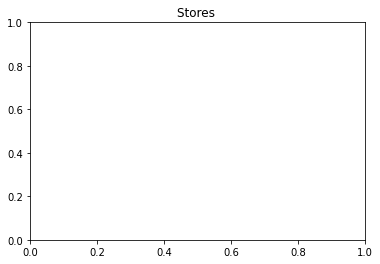

In [64]:
plt.title('Stores ')
sns.countplot(data= final_train_df,  x = "store_type");

In [287]:
avg_sd = final_train_df.groupby(["Year", 
                                 "store_type"]).agg({"sales":"mean"}).sort_values('store_type', 
                                                                                  ascending=True).reset_index()
fig = px.box(avg_sd, y="sales", facet_col="store_type",
             color= 'store_type',
             boxmode="overlay", points='all')

fig.layout.update({'width':700,'height':500})
fig.update_layout(title = "Average Sales Distribution")
fig.update_layout(title_x=0.5)
fig.show()

In [139]:
def create_date_features(df):
    df['WeekofYear'] = (df['date'].dt.isocalendar().week)
    df['Month'] = df['date'].dt.month
    df['Year'] = df['date'].dt.year
    df['Day'] = df['date'].dt.day.astype('uint8') 
    df['WeekofYear']= df['WeekofYear'].astype('uint8')
    df['Month'] = df['Month'].astype('uint8')
    df['Year'] = df['Year'].astype('uint16')
    df['Day'] = df['Day'].astype('uint8')             
    return df

In [140]:
final_train_df = create_date_features(final_train_df)
final_test_df = create_date_features(final_test_df)

In [292]:
def convert_to_size(x):
    if x < 50:
        return 6
    elif x < 100:
        return 10
    elif x < 150:
        return 15
    elif x < 250:
        return 18 
    elif x < 300:
        return 24 
    elif x < 500:
        return 30 
    else:
        return 40

def bubble(col1, col2):
    vc = final_train_df.groupby([col1, col2]).agg({"sales" : "mean"}).reset_index()
    vc = vc.sort_values(col2)    
    fig = px.scatter(vc, x=col1, y=col2, 
                     size='sales',color='sales', 
                     color_continuous_scale=px.colors.diverging.BrBG,
                     size_max=40)
    fig.update_layout(title = "Average Sales by "+col1+" and " + col2)
    fig.update_layout({'width':800,'height':400})
    fig.update_layout(title_x=0.2)
    fig.show()

In [460]:
bubble('Month', 'day_type')
bubble('Month', 'store_type')

Every store have peak days in Christmas season. Some stores show upper trends.

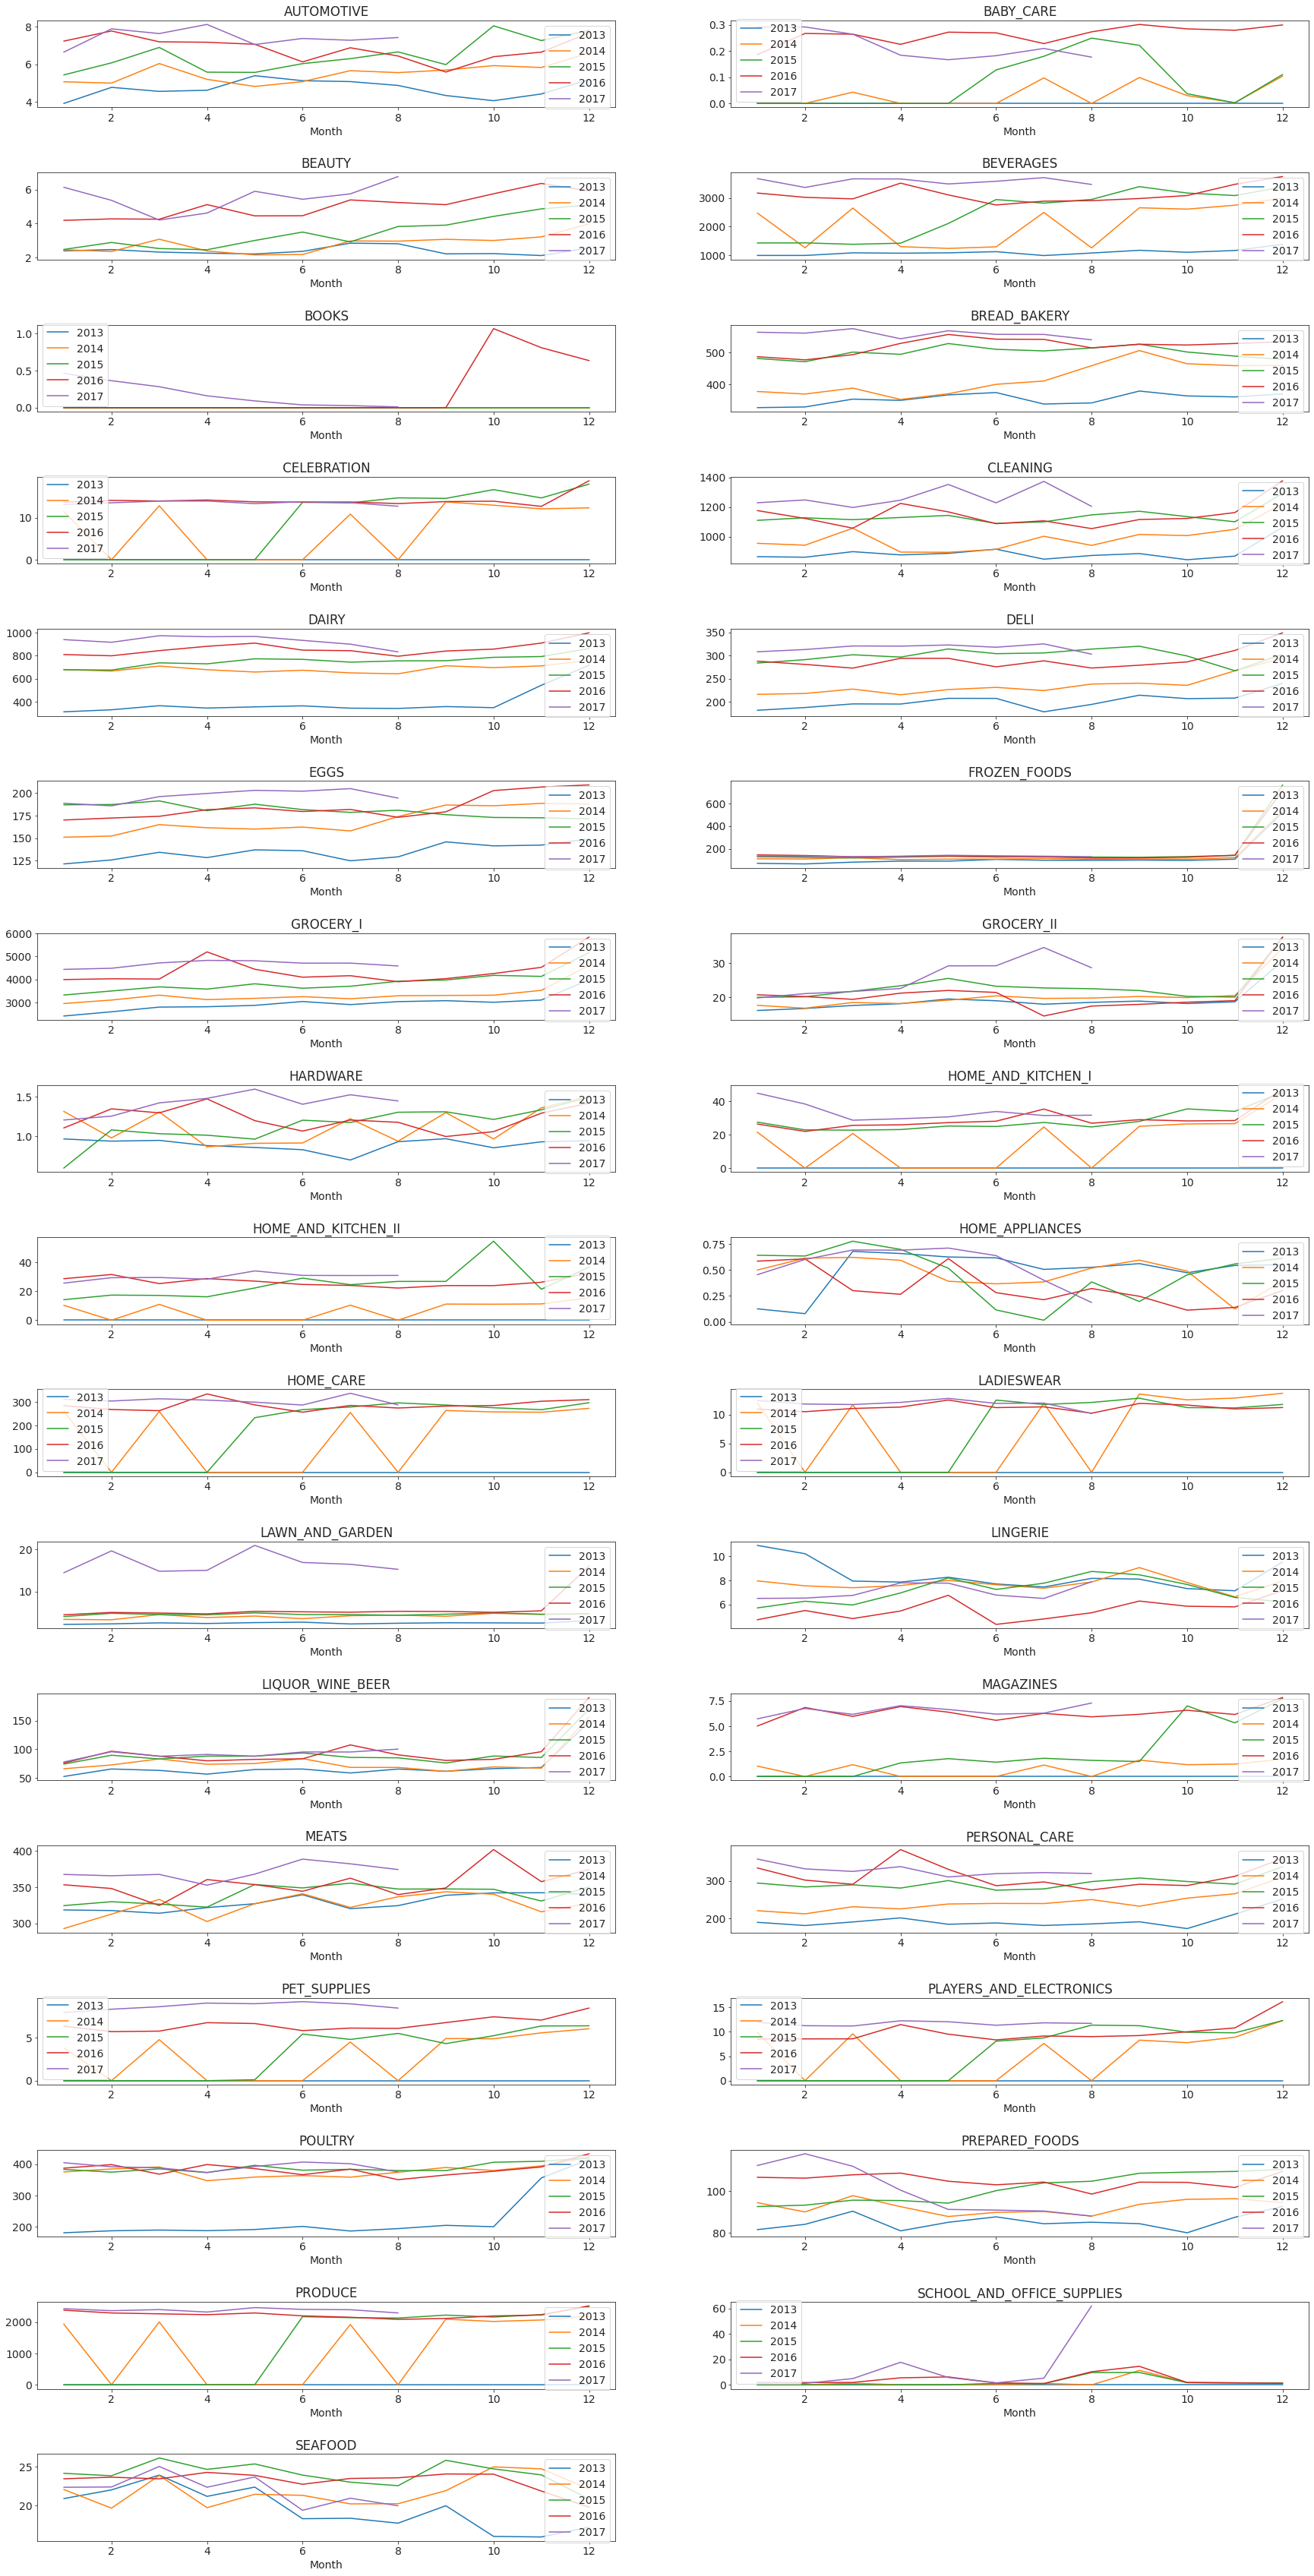

In [283]:
fig= plt.figure(figsize=(30,120))
fig.subplots_adjust(hspace=0.75)
for i,product in enumerate(final_train_df.family.unique()):
    ax = fig.add_subplot(33,2,i+1)
    select = final_train_df.query('family==@product')
    for year in [2013,2014,2015,2016,2017]: 
        select.query('Year==@year').groupby('Month').sales.mean().plot(ax=ax,label=year)
    plt.title(product)
    ax.legend();

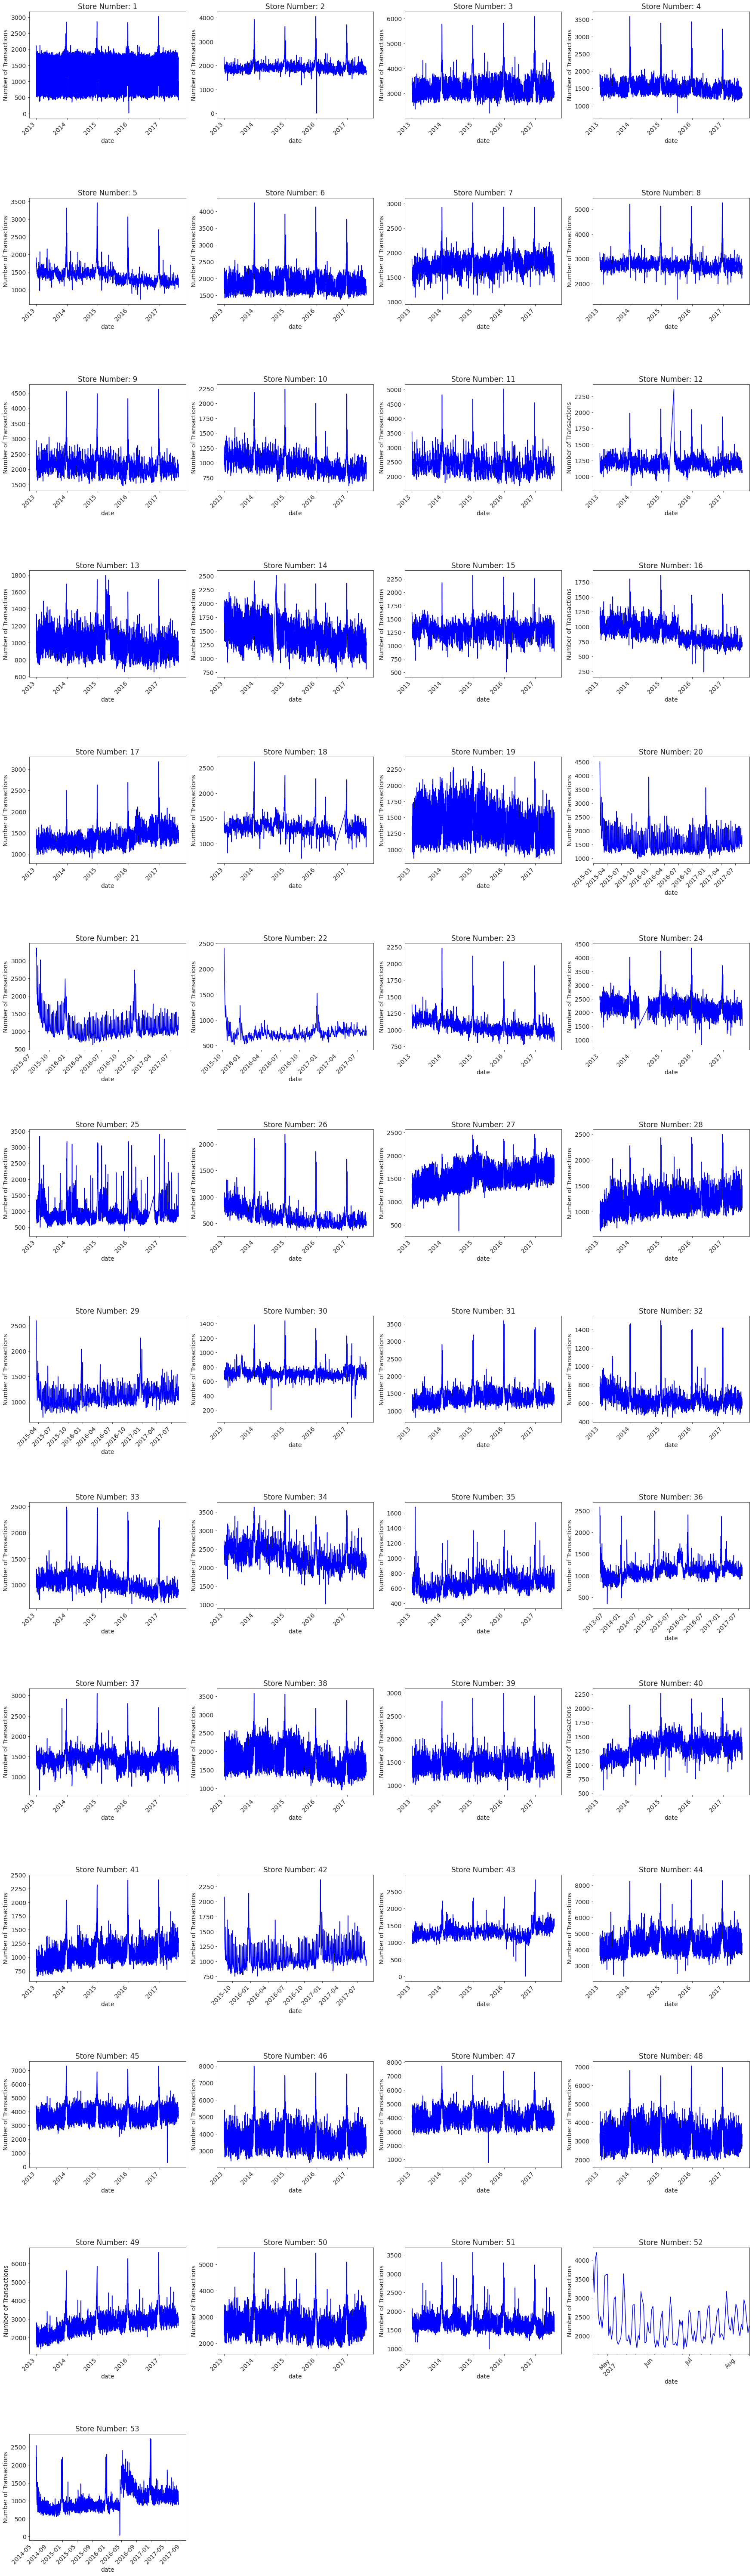

In [259]:
fig= plt.figure(figsize=(30,120))
fig.subplots_adjust(hspace=0.75)
for i,store in enumerate(range(1,54)):
    ax = fig.add_subplot(14,4,i+1)
    transactions_df.set_index('date').query('store_nbr==@store').transactions.plot(c='blue');
    plt.title('Store Number: ' + str(store));
    plt.ylabel('Number of Transactions')
    plt.xticks(rotation=45);

In [285]:
final_train_df.groupby(["Year", "store_nbr"]).sales.sum().reset_index()

,Year,store_nbr,sales
0,2013,1,1.894713e+06
1,2013,2,2.865393e+06
2,2013,3,6.462661e+06
3,2013,4,2.611982e+06
4,2013,5,2.579358e+06
...,...,...,...
265,2017,50,4.915228e+06
266,2017,51,5.364285e+06
267,2017,52,2.696170e+06
268,2017,53,2.711539e+06


In [256]:
ex_df = stores_df.groupby(['city', 'type']).count()[['store_nbr']].reset_index(level=0).reset_index(level=0)[['city', 'type', 'store_nbr']]
map_colors = {'A': '#96ceb4', 'B':'#ffeead', 'C':'#ffcc5c', 'D':'#ff6f69', 'E':'#ffff99'}
ex_df['colors'] = ex_df['type'].map(map_colors)

#SALES 
trace= go.Bar(y=ex_df['store_nbr'],
              x=ex_df['city'],
              text = ex_df["type"],
              marker=dict(color= ex_df['colors']))

##styling 
fig = go.Figure(data = trace)
fig.update_xaxes(visible=True)
fig.layout.update({'title': 'Number of Stores in each City by Type'})
fig.update_yaxes(showgrid=False)
fig.update_layout(title_x=0.5,
                  template="ggplot2",
                  bargap=0.4,
                  height=700,
                  width=800,
                  showlegend=False)

fig.show()

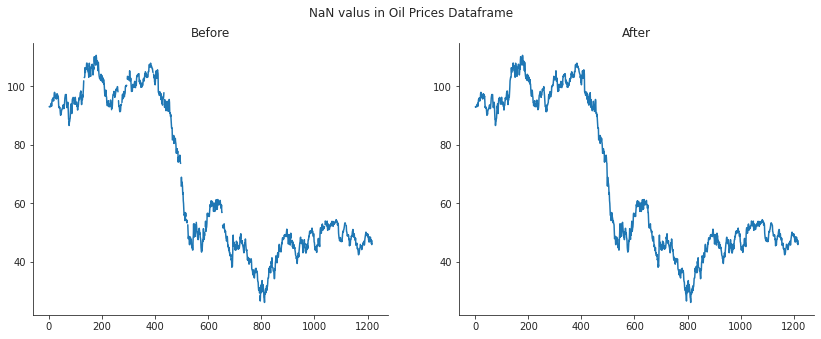

In [297]:
oil_df1 = pd.read_csv('./store-sales-time-series-forecasting/oil.csv')
fig,axes = plt.subplots(1,2,figsize= (14,5))
oil_df1['dcoilwtico'].plot(ax=axes[0])
oil_df['dcoilwtico'].plot(ax=axes[1])
#merged_train_df[single_store_dept_mask2].plot(y='Weekly_Sales', x='Date', label = 'Dept72', ax=ax)

#sns.countplot(data= oil_df1['dcoilwtico'],  x = "Type", ax=axes[0])
axes[0].set_title("Before")

#sns.stripplot(data= oil_df['dcoilwtico'], x="Type", y= "Size", ax = axes[1])
axes[1].set_title("After")

fig.suptitle("NaN valus in Oil Prices Dataframe")
sns.despine();

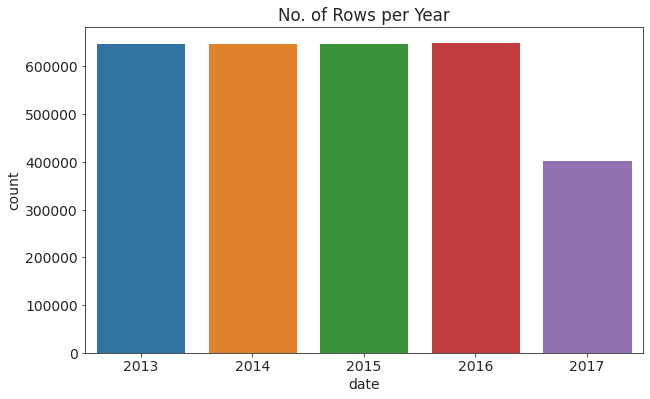

In [222]:
plt.title('No. of Rows per Year')
sns.countplot(x=pd.to_datetime(final_train_df.date).dt.year);

In [ ]:
'''
#corr
df_lag_corr = df_lag[[col for col in list(df_lag.columns) if col.startswith('sales_')]]
plt.figure(figsize=(10,10))
sns.heatmap(df_lag_corr.corr(), annot=True, cmap="YlGnBu")
plt.show()
'''

## Feature Engineering

In [298]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
# Input and target columns

input_cols= ['onpromotion','cluster','dcoilwtico',
             'family', 'city', 'state', 'store_type', 
             'day_type', 'locale']
input_cols1= ['family', 'onpromotion', 'city', 
              'state', 'type', 'cluster','dcoilwtico']
# Non Scaling cols
transferred= ['transferred']
store_nbr= ['store_nbr']
dates = ['WeekofYear','Month','Year','Day']
target_col = 'sales'

In [299]:
inputs_df = final_train_df.copy()
targets_df = final_train_df[target_col].copy()
targets_df= targets_df.apply(pd.np.log1p)
#.apply(pd.np.expm1)
test_inputs_df = final_test_df.copy()

In [300]:
# Numerical and Categorical columns

numeric_cols = final_train_df[input_cols].select_dtypes(include=np.number).columns.tolist()
categorical_cols = final_train_df[input_cols].select_dtypes(include='object').columns.tolist()

In [301]:
# Scale numeric columns (Check accuracy with and without)

scaler = MinMaxScaler().fit(inputs_df[numeric_cols])

inputs_df[numeric_cols] = scaler.transform(inputs_df[numeric_cols])
test_inputs_df[numeric_cols] = scaler.transform(test_inputs_df[numeric_cols])

In [302]:
# One-hot encode categorical columns

encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(inputs_df[categorical_cols])

encoded_cols = list(encoder.get_feature_names(categorical_cols))

In [303]:
inputs_df[encoded_cols] = encoder.transform(inputs_df[categorical_cols])
inputs_df[encoded_cols]=inputs_df[encoded_cols].astype('uint8')
test_inputs_df[encoded_cols] = encoder.transform(test_inputs_df[categorical_cols])
test_inputs_df[encoded_cols]= test_inputs_df[encoded_cols].astype('uint8')

In [304]:
# Create training and validation sets
from sklearn.model_selection import train_test_split

train_inputs, val_inputs, train_targets, val_targets = train_test_split(
    inputs_df[dates + store_nbr + transferred + numeric_cols + encoded_cols], 
    targets_df, test_size=0.10, random_state=42)

In [305]:
X_test = test_inputs_df[dates + transferred + store_nbr + numeric_cols + encoded_cols]

In [306]:
#train_inputs, val_inputs
#train_targets, val_targets

## Evaluation Metric

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html

The evaluation metric for this competition is Root Mean Squared Logarithmic Error.

The RMSLE is calculated as:
[\sqrt{ \frac{1}{n} \sum_{i=1}^n \left(\log (1 + \hat{y}_i) - \log (1 + y_i)\right)^2}]
where:

 is the total number of instances,
 is the predicted value of the target for instance (i),
 is the actual value of the target for instance (i), and,
 is the natural logarithm.

Helper function for evaluation metric

In [307]:
pd.options.display.float_format = '{:,.2f}'.format

from sklearn.metrics import mean_squared_log_error

def eval_metrics(targets, pred):
  # Targets = Train targets or Val targets (tarin_targets / val_targets)
  # pred = model.preds
   rmsle = round(mean_squared_log_error(targets, pred, squared= False),4)

   return {'RMSLE': rmsle}

## ML Modeling

### Base Model

In [308]:
base_model1 = final_train_df.groupby(['store_nbr','store_type']).sales.transform('median')
base_model2 = final_train_df.groupby(['store_nbr','store_type']).sales.transform('mean')
print(eval_metrics(final_train_df.sales, base_model1))
print(eval_metrics(final_train_df.sales, base_model2))

{'RMSLE': 2.6705}
{'RMSLE': 3.7939}


In [309]:
!pip install xgboost scikit-learn lightgbm --upgrade --quiet

     |████████████████████████████████| 255.9 MB 47 kB/s 
     |████████████████████████████████| 2.0 MB 44.1 MB/s 


In [310]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

### Linear Regression

In [312]:
%%time
linear_model= LinearRegression()
linear_model.fit(train_inputs, train_targets)

CPU times: user 38.1 s, sys: 3.5 s, total: 41.6 s
Wall time: 34.3 s


LinearRegression()

In [313]:
lm_t_preds = linear_model.predict(train_inputs)
lm_v_preds = linear_model.predict(val_inputs)
lm_t_preds[lm_t_preds<0]=0
lm_v_preds[lm_v_preds<0]=0

In [314]:
print("train_error", eval_metrics(train_targets, lm_t_preds))
print("val_error", eval_metrics(val_targets, lm_v_preds))

train_error {'RMSLE': 0.5125}
val_error {'RMSLE': 0.5116}


### Decision Tree Regressor

In [315]:
%%time
dtree_model= DecisionTreeRegressor()
dtree_model.fit(train_inputs, train_targets)

CPU times: user 2min 31s, sys: 283 ms, total: 2min 31s
Wall time: 2min 43s


DecisionTreeRegressor()

In [316]:
dtm_t_preds = dtree_model.predict(train_inputs)
dtm_v_preds = dtree_model.predict(val_inputs)

In [317]:
print(dtree_model)
print('max_features',dtree_model.max_features_)
print('max_depthd',dtree_model.tree_.max_depth)
print('n_leaves',dtree_model.tree_.n_leaves)
print("train_error", eval_metrics(train_targets, dtm_t_preds))
print("val_error", eval_metrics(val_targets, dtm_v_preds))

DecisionTreeRegressor()
max_features 91
max_depthd 73
n_leaves 1862135
train_error {'RMSLE': 0.0}
val_error {'RMSLE': 0.2471}


In [ ]:
dtree_test_preds = dtree_model.predict(X_test)
submission_df= pd.DataFrame({'id': final_test_df.id,
                            'sales':dtree_test_preds})
submission_df.to_csv('no_hp_dt_preds.csv',index=False)

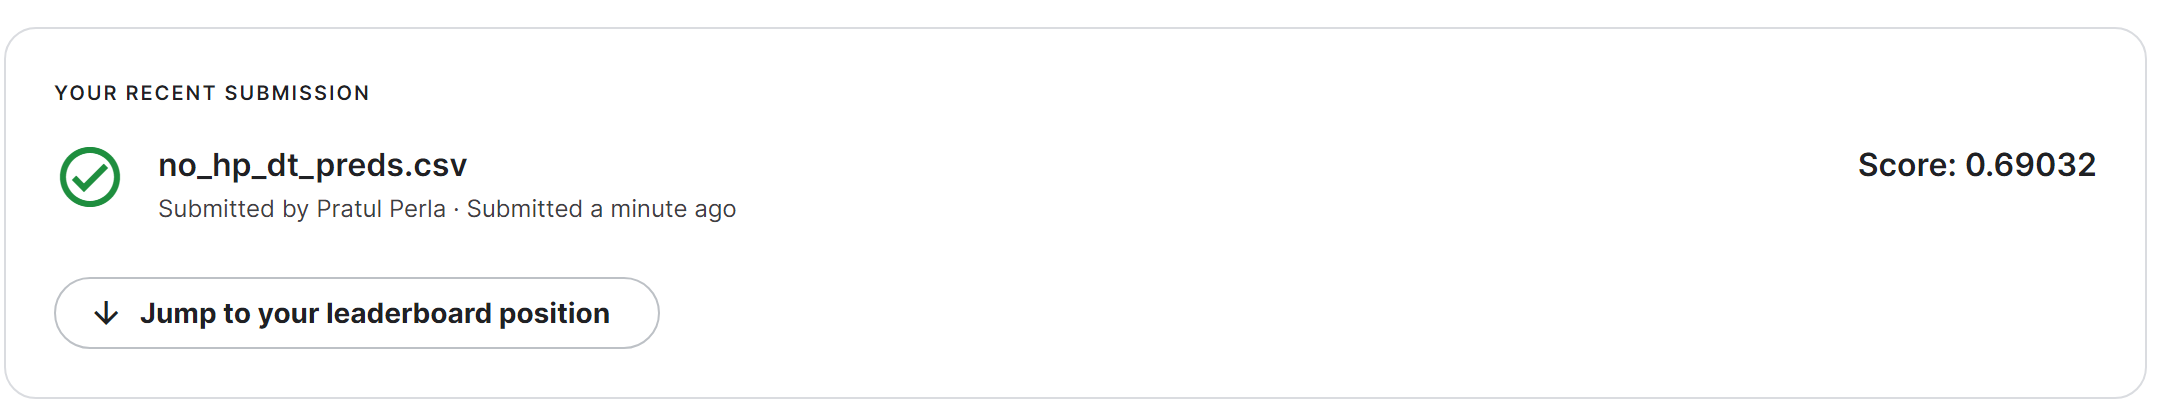

### Ridge Regressor

In [318]:
%%time
from sklearn.linear_model import Ridge
rdg_model = Ridge()
rdg_model.fit(train_inputs, train_targets)

CPU times: user 3.66 s, sys: 195 ms, total: 3.85 s
Wall time: 4.23 s


Ridge()

In [319]:
rdg_t_preds = rdg_model.predict(train_inputs)
rdg_v_preds = rdg_model.predict(val_inputs)
rdg_t_preds[rdg_t_preds<0]=0
rdg_v_preds[rdg_v_preds<0]=0

In [320]:
print("train_error", eval_metrics(train_targets, rdg_t_preds))
print("val_error", eval_metrics(val_targets, rdg_v_preds))

train_error {'RMSLE': 0.5125}
val_error {'RMSLE': 0.5116}


### XGBRegressor

In [ ]:
%%time
xgb_model= XGBRegressor(random_state = 42, n_jobs = -1)
xgb_model.fit(train_inputs, train_targets)

CPU times: user 34min 42s, sys: 5.12 s, total: 34min 47s
Wall time: 19min 14s


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)

In [ ]:
xgb_model

In [ ]:
xgbm_t_preds = xgb_model.predict(train_inputs)
xgbm_v_preds = xgb_model.predict(val_inputs)
xgbm_t_preds[xgbm_t_preds<0]=0
xgbm_v_preds[xgbm_v_preds<0]=0

In [ ]:
print("train_error", eval_metrics(train_targets, xgbm_t_preds))
print("val_error", eval_metrics(val_targets, xgbm_v_preds))

train_error {'RMSLE': 1.6797}
val_error {'RMSLE': 1.6798}


Storing Models

In [ ]:
store_sales = {
    'linear_model': linear_model,
    'dtree_model': dtree_model,
    #'sgd_model': sgd_model, (very bad score: 3.5+ rmsle)
    #'xgb_model': xgb_model, (took 20 mins to train & bad score: 3.5+ rmsle)
    'scaler': scaler,
    'encoder': encoder,
    'store_nbr': store_nbr,
    'dates': dates,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [ ]:
import joblib
joblib.dump(store_sales, 'store_sales.joblib')
# Loading dump
# saved_dump = joblib.load('store_sales.joblib')

['store_sales.joblib']

In [ ]:
jovian.commit(outputs=['store_sales.joblib'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Uploading additional outputs...


[jovian] Error: ('Connection aborted.', BrokenPipeError(32, 'Broken pipe')) (store_sales.joblib)


Committed successfully! https://jovian.ai/pratulofficialthings/store-sales-time-series-forecasting


'https://jovian.ai/pratulofficialthings/store-sales-time-series-forecasting'

### LightGBM

In [321]:
%%time
lgbm_model = LGBMRegressor(boosting_type='gbdt', 
                           num_leaves= 10000, learning_rate= 0.1,
                           max_depth= 10, n_estimators=100)
lgbm_model.fit(train_inputs, train_targets,
        eval_set=[(val_inputs, val_targets)],
        eval_metric='mse')
lgbm_t_preds = lgbm_model.predict(train_inputs, num_iteration=lgbm_model.best_iteration_)
lgbm_v_preds = lgbm_model.predict(val_inputs, num_iteration=lgbm_model.best_iteration_)

[1]	valid_0's l2: 6.37817
[2]	valid_0's l2: 5.65266
[3]	valid_0's l2: 5.11781
[4]	valid_0's l2: 4.60388
[5]	valid_0's l2: 4.22985
[6]	valid_0's l2: 3.85401
[7]	valid_0's l2: 3.56973
[8]	valid_0's l2: 3.29671
[9]	valid_0's l2: 3.05952
[10]	valid_0's l2: 2.87998
[11]	valid_0's l2: 2.69858
[12]	valid_0's l2: 2.56041
[13]	valid_0's l2: 2.41755
[14]	valid_0's l2: 2.29412
[15]	valid_0's l2: 2.16971
[16]	valid_0's l2: 2.06695
[17]	valid_0's l2: 1.98079
[18]	valid_0's l2: 1.86909
[19]	valid_0's l2: 1.7795
[20]	valid_0's l2: 1.71438
[21]	valid_0's l2: 1.63877
[22]	valid_0's l2: 1.5788
[23]	valid_0's l2: 1.50452
[24]	valid_0's l2: 1.44151
[25]	valid_0's l2: 1.38079
[26]	valid_0's l2: 1.32057
[27]	valid_0's l2: 1.28438
[28]	valid_0's l2: 1.23621
[29]	valid_0's l2: 1.1939
[30]	valid_0's l2: 1.14586
[31]	valid_0's l2: 1.12195
[32]	valid_0's l2: 1.07791
[33]	valid_0's l2: 1.05158
[34]	valid_0's l2: 1.01206
[35]	valid_0's l2: 0.992612
[36]	valid_0's l2: 0.970388
[37]	valid_0's l2: 0.937893
[38]	valid

In [322]:
lgbm_t_preds[lgbm_t_preds<0]=0
lgbm_v_preds[lgbm_v_preds<0]=0

In [323]:
print("train_error", eval_metrics(train_targets, lgbm_t_preds))
print("val_error", eval_metrics(val_targets, lgbm_v_preds))

train_error {'RMSLE': 0.281}
val_error {'RMSLE': 0.2823}


## Hypertuning Parameters

In [324]:
def test_params(**params):
    # Model
    model = DecisionTreeRegressor(random_state=42, **params).fit(train_inputs, train_targets)
    # Evaluation
    train_rmsle = eval_metrics(train_targets, model.predict(train_inputs))
    val_rmsle = eval_metrics(val_targets, model.predict(val_inputs))
    t_r= train_rmsle['RMSLE']
    v_r= val_rmsle['RMSLE']
    return t_r, v_r

def test_param_and_plot(param_name, param_values):
    train_errors, val_errors = [], [] 
    # Ploting each error
    for value in param_values:
        params = {param_name: value}
        t_r, v_r= test_params(**params)
        train_errors.append(t_r)
        val_errors.append(v_r)
    plt.figure(figsize=(10,6))
    plt.title('Overfitting curve: ' + param_name)
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.xlabel(param_name)
    plt.ylabel('RMSLE')
    plt.legend(['Training', 'Validation'])

In [325]:
rng=[]
i=5
while i< 80 :
  rng.append(i)
  i=i+5
rng

[5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75]

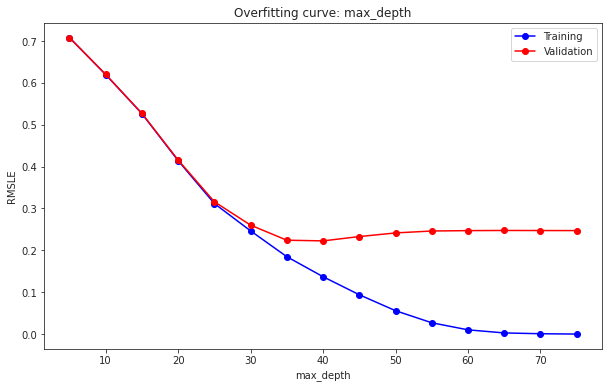

In [326]:
test_param_and_plot('max_depth', rng)

In [347]:
test_params(max_depth=40, min_samples_leaf=5)

(0.1704, 0.2073)

In [360]:
%%time
dtree_model= DecisionTreeRegressor(max_depth=40, min_samples_split=5,
                                   random_state=42, min_samples_leaf=2)
dtree_model.fit(train_inputs, train_targets)

CPU times: user 1min 58s, sys: 243 ms, total: 1min 58s
Wall time: 1min 58s


DecisionTreeRegressor(max_depth=40, min_samples_leaf=2, min_samples_split=5,
                      random_state=42)

In [365]:
dtree_model.get_params(deep=True)

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 40,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [361]:
dtm_t_preds = dtree_model.predict(train_inputs)
dtm_v_preds = dtree_model.predict(val_inputs)
print("train_error", eval_metrics(train_targets, dtm_t_preds))
print("val_error", eval_metrics(val_targets, dtm_v_preds))

train_error {'RMSLE': 0.1528}
val_error {'RMSLE': 0.2123}


## Moving Average

In [403]:
# Date Features
def create_date_features_Date(df):
    df['month'] = df.Date.dt.month
    df['day_of_month'] = df.Date.dt.day
    df['day_of_year'] = df.Date.dt.dayofyear
    df['week_of_year'] = df.Date.dt.weekofyear
    df['day_of_week'] = df.Date.dt.dayofweek
    df['year'] = df.Date.dt.year
    return df

In [404]:
# Exponentially Weighted Mean Features
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [405]:
# Feature Importance
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feature_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feature_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feature_imp.head(num)) 

In [446]:
df_train = pd.read_csv("./store-sales-time-series-forecasting/train.csv",index_col=0)
df_test = pd.read_csv("./store-sales-time-series-forecasting/test.csv",index_col=0)
df_transactions = pd.read_csv("./store-sales-time-series-forecasting/transactions.csv")
df_stores = pd.read_csv("./store-sales-time-series-forecasting/stores.csv")
df_holidays = pd.read_csv("./store-sales-time-series-forecasting/holidays_events.csv")
df_oil = pd.read_csv("./store-sales-time-series-forecasting/oil.csv")

In [447]:
import numpy as np
df_oil.dcoilwtico[0]=93.00

for i in list(df_oil[df_oil.dcoilwtico.isna()].index):
  p= i-1
  c= i+1
  mean = np.mean([df_oil.dcoilwtico[p],
                  df_oil.dcoilwtico[c]])
  df_oil.dcoilwtico[i]=mean

df_oil.dcoilwtico[1174]=46.02
df_oil.dcoilwtico[1175]=46.02
df_oil['date'] = df_oil['date'].astype("datetime64")

In [448]:
df_date = pd.DataFrame(pd.date_range("2013-01-01","2017-08-31"),columns=["date"])
df_oil = df_date.merge(df_oil,left_on='date',right_on='date',how='left').fillna(method='ffill').fillna(method='bfill')

df_all = df_train.append(df_test)
df_all = df_all.merge(df_stores,left_on="store_nbr",right_on="store_nbr",how="left")

df_holidays = df_holidays.rename(columns = {"type":"Holiday_type"})
df_all = df_all.merge(df_holidays,left_on="date",right_on="date",how="left")

df_all = df_all.merge(df_transactions,left_on=["date","store_nbr"],
                      right_on=["date","store_nbr"],how="left")

df_all["date"] = df_all["date"].astype("datetime64")
df_all = df_all.merge(df_oil,left_on="date",right_on="date",how="left")
df_all = df_all.replace(",","_",regex=True)
df_all = df_all.rename(columns = {"date":"Date"})

In [449]:
col = ['Date','store_nbr','family','sales','onpromotion',
       'city', 'state', 'type', 'locale_name',#
       'cluster','Holiday_type','locale','description', 
       'transferred','dcoilwtico']

df = df_all[col]

In [450]:
df["store_nbr"] = df["store_nbr"].astype("category")
df["family"] = df["family"].astype("category")
df["onpromotion"] = df["onpromotion"].astype("int64")
df["city"] = df["city"].astype("category")#
df["state"] = df["state"].astype("category")#
df["type"] = df["type"].astype("category")#
df["Holiday_type"] = df["Holiday_type"].astype("category")
df["locale"] = df["locale"].astype("category")
df["locale_name"] = df["locale_name"].astype("category")#
df["description"] = df["description"].astype("category")
df["transferred"] = df["transferred"].astype("category")

######################### lags = [16, 30, 60, 90]
alphas = [0.95, 0.9, 0.8, 0.5]
lags =[1, 6, 7, 8, 30]
df = ewm_features(df, alphas, lags)
#######################

df['sales'] = np.log1p(df["sales"].values)

In [451]:
#Train Test Split
df= df[df["Date"]>"2013-12-31"]
val = df[(df["Date"]>"2017-08-01")&(df["Date"]<="2017-08-15")]
train  = df[df["Date"]<="2017-08-01"]
test = df[df["Date"]>"2017-08-15"]

col_X = [col for col in train.columns if col not in ['Date', 'sales','year']]

y_train = train["sales"]
y_val = val["sales"]
X_train = train[col_X]
X_val = val[col_X]
X_test = test[col_X]
y_test = test["sales"]

In [452]:
# LightGBM parameters
lgb_params = {'metric': {'mse'},
              'boosting_type' : 'gbdt',
              'num_leaves': 8,
              'learning_rate': 0.2,
              #'feature_fraction': 0.8,
              'max_depth': 7,
              'verbose': 0,
              'num_boost_round': 5000,
              'early_stopping_rounds': 200,
              'nthread': -1,
             'force_col_wise':True}

lgbtrain = lgb.Dataset(data=X_train, label=y_train, feature_name=col_X)
lgbtest = lgb.Dataset(data=X_val, label=y_val, reference=lgbtrain, feature_name=col_X)

In [453]:
from sklearn.metrics import mean_absolute_error
model = lgb.train(lgb_params, lgbtrain,
                  valid_sets=[lgbtrain, lgbtest],
                  num_boost_round=lgb_params['num_boost_round'],
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=200,
                  )

Training until validation scores don't improve for 200 rounds
[200]	training's l2: 0.188873	valid_1's l2: 0.167408
[400]	training's l2: 0.178178	valid_1's l2: 0.161521
[600]	training's l2: 0.172396	valid_1's l2: 0.158972
[800]	training's l2: 0.167874	valid_1's l2: 0.157394
[1000]	training's l2: 0.164544	valid_1's l2: 0.156749
[1200]	training's l2: 0.162022	valid_1's l2: 0.156374
[1400]	training's l2: 0.159981	valid_1's l2: 0.155994
[1600]	training's l2: 0.158043	valid_1's l2: 0.155413
[1800]	training's l2: 0.1565	valid_1's l2: 0.15551
Early stopping, best iteration is:
[1636]	training's l2: 0.157773	valid_1's l2: 0.155321


In [454]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
y_pred_val[y_pred_val<0]=0
eval_metrics(y_val, y_pred_val)

{'RMSLE': 0.1644}

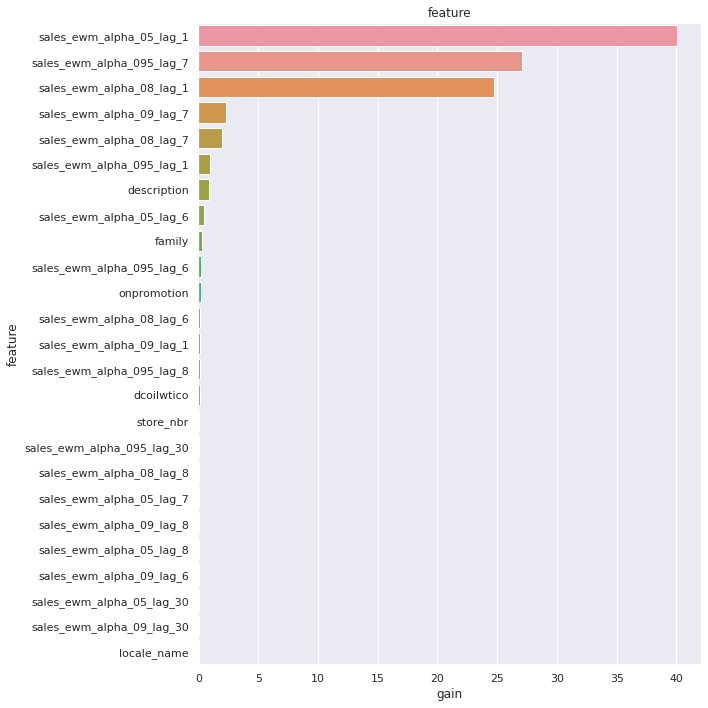

In [455]:
plot_lgb_importances(model, plot=True, num=10)

In [391]:
submission = pd.read_csv("./store-sales-time-series-forecasting/sample_submission.csv")
y_test = model.predict(X_test, num_iteration=model.best_iteration)
y_test[y_test<0]=0
submission["sales"] = np.expm1(y_test)

In [392]:
submission.to_csv("final_submission.csv",index=False)
submission

,id,sales
0,3000888,3.64
1,3000889,0.00
2,3000890,4.93
3,3000891,"2,231.98"
4,3000892,0.03
...,...,...
28507,3029395,417.41
28508,3029396,136.06
28509,3029397,"1,903.25"
28510,3029398,112.75


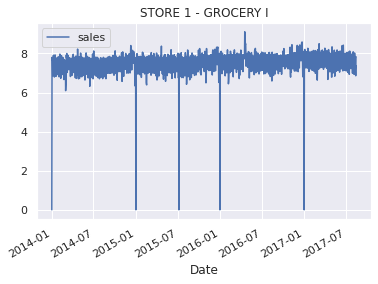

In [462]:
df[(df.store_nbr == 1) & (df.family == "GROCERY I")].set_index("Date")\
[["sales", "sales_ewm_alpha_095_lag_7"]].plot(title = "STORE 1 - GROCERY I");

Reference:

https://towardsdatascience.com/an-algorithm-to-find-the-best-moving-average-for-stock-trading-1b024672299c

In [ ]:
import jovian

In [463]:
# Execute this to save new versions of the notebook
jovian.commit(project="store-sales-time-series-forecasting")

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
Committed successfully! https://jovian.ai/pratulofficialthings/store-sales-time-series-forecasting


'https://jovian.ai/pratulofficialthings/store-sales-time-series-forecasting'